# Decision Making Under Uncertainty - Assignment 1

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

In [1]:
import random
import math
import itertools
import re

import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gb
from scipy import stats
import statistics
import pandas as pd

In [2]:
# Set parameters
num_instances = 10
num_items = 10
g = 2 # group number
alpha_model = {"EV": 0, "CVaR": 0.95}
beta_model = {"EV": 0, "CVaR": 1}

# Generation of Problem Instances
## Part 1
In the first part, we want to generate 10 random instances of the Stochastic Knapsack Problem (SKP). For this, we need to generate values for the low weights using the Poisson distribution. From Lab 2, we know that the `numpy.random` library is the fastest in doing this. For the high weights, we will use the same library, using the `triangular()` function from `numpy.random`.


In [3]:
def generate_instance(num_items, g, seed):
    """Generate a dictionary of `num_items` possible item sizes

    Parameters
    ----------
    num_items : int
        Number of items to generate weights for
    g : int
        Group number
    seed : int
        Random seed

    Returns
    -------
    item_sizes : dict
        Dictionary containing the possible item sizes
    """

    # Assert inputs are of correct form
    assert isinstance(num_items, int), "num_items is not an int"
    assert isinstance(g, int), "g is not an int"
    assert isinstance(seed, int), "seed is not an int"

    # Generate possible item sizes.
    np.random.seed(seed)
    lam = [math.ceil((i + 1)/2) for i in range(num_items)]
    dl = np.minimum(np.random.poisson(lam), 10)
    dh = [np.random.triangular(90 + g - (i+1), 100 + g - (i+1), 110 + g - (i+1))
          for i in range(num_items)]

    item_sizes = {"dl": dl, "dh": dh}

    return item_sizes

In [4]:
def skp(num_instances, num_items, g):
    """Generates `num_instances` instances of a Stochastic Knapsack Problem (SKP).

    Parameters
    ----------
    num_instances : int
        Number of instances of the SKP to generate
    num_items : int
        Number of items to consider per instance
    g : int
        Group number

    Returns
    -------
    instance : tuple
        Tuple containing the unit excess weight penalty `p`, knapsack capacity `K`, item size
        probability vector `pi`, revenue vector `r`, and possible item sizes `item_sizes`,
        respectively.
    """

    # Assert inputs are of correct form
    assert isinstance(num_instances, int), "num_instances is not an int"
    assert isinstance(num_items, int), "num_items is not an int"
    assert isinstance(g, int), "g is not an int"

    # Generate instance variables
    p = math.floor(60 + 0.1 * g)  # Unit excess weight penalty
    K = 400 + 4 * g  # Knapsack capacity

    pi = np.asarray([0.5 + 0.05 * (i + 1) - 0.001 for i in range(num_items)])
    r = np.asarray([51 - (i + 1) for i in range(num_items)])

    item_sizes = {j: generate_instance(num_items, g, seed=j) for j in range(num_instances)}

    instance = (p, K, pi, r, item_sizes)

    return instance

In [5]:
p, K, pi, r, item_sizes = skp(num_instances, num_items, g)
print(pi)

[0.549 0.599 0.649 0.699 0.749 0.799 0.849 0.899 0.949 0.999]


# Heuristic Algorithm
## Part 2

In [6]:
def greedy_algorithm(problem_instance, pi, r, item_sizes, K):
    """Using a greedy algorithm, selects items to use in a Stochastic Knapsack Problem.
    
    Parameters
    ----------
    problem_instance : int
        Integer specifying which problem instance to take. Note that this number needs to be a key
        in `item_sizes`.
    pi : list or numpy.array
        Probabilities specifying whether an item will attain a high weight.
    r : list or numpy.array
        Per-unit revenue. Note that this means that if we take M amounts of item i, then the
        revenue is r[i]*M, not r[i].
    item_sizes : dict
        Dictionary with as keys the problem instance number and as values a dictionary of which the
        keys are 'dl' and 'dh', specifying the low and high weight, respectively, and the values are
        the corresponding weights for each item.
    K : int
        Knapsack capacity.
    
    Returns
    -------
    x : numpy.array
        Specifies which items are selected with a 1 if an item is selected and 0 otherwise.
    """

    # Compute expectation of w_i for each item
    Ew = item_sizes[problem_instance]["dh"] * np.array(pi) + \
        item_sizes[problem_instance]["dl"] * (np.array(1) - pi)
        
    sorted_expected_revenue = np.argsort(r)[::-1]

    # Initialise zero-value x and W
    x = np.zeros(10, dtype=np.int16)
    W = 0

    while len(sorted_expected_revenue) != 0:

        consider_item = sorted_expected_revenue[0]

        if W + Ew[consider_item] <= K:
            x[consider_item] = 1
            W = W + Ew[consider_item]

        sorted_expected_revenue = np.delete(sorted_expected_revenue, 0)

    return x

# Monte Carlo Simulation
## Part 3

In [7]:
problem_instance = 0
x = greedy_algorithm(problem_instance, pi, r, item_sizes, K)
print("x:", x)

x: [1 1 1 1 1 1 0 0 0 0]


In [8]:
num_items

10

In [9]:
x

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int16)

In [10]:
def calculate_profits(item_sizes, x, r, pi, problem_instance, num_runs):
    """Calculates the profits based on realised item sizes.

    Parameters
    ----------
    item_sizes : dict
        Dictionary with as keys the problem instance number and as values a dictionary of which the
        keys are 'dl' and 'dh', specifying the low and high weight, respectively, and the values are
        the corresponding weights for each item.
    x : numpy.array
        Specifies which items are selected with a 1 if an item is selected and 0 otherwise.
    r : list or numpy.array
        Per-unit revenue. Note that this means that if we take M amounts of item i, then the
        revenue is r[i]*M, not r[i].
    pi : list or numpy.array
        Probabilities specifying whether an item will attain a high weight.
    problem_instance : int
        Integer specifying which problem instance to take. Note that this number needs to be a key
        in `item_sizes`.
    num_runs : int
        Integer specifying the number of runs for which to calculate the profits.

    Returns
    -------
    profits : numpy.array
        Specifies the profits following `num_runs` simulations of instance `problem_instance`.
    """

    profits = []
    num_items = len(x)

    for _ in range(num_runs):
        u = np.random.uniform(size=num_items)
        w = [item_sizes[problem_instance]["dh"][i] if u[i] < pi[i]
             else item_sizes[problem_instance]["dl"][i] for i in range(num_items)]
        w = np.asarray(w)

        total_weight = np.dot(x, w)
        excess = max(total_weight-K, 0)

        profit = np.dot(x, r*w) - excess*p
        profits.append(profit)

    profits = sorted(profits)

    return profits


We want to calculate the optimal number of runs for running our Monte Carlo simulation. For this, we need to first get an estimate for the standard deviation of the distribution of the profits...

### Note: look at np.std function again. I think we're not doing it correctly formula for np.std that Python uses is
\begin{align*}
            \hat{\sigma} = \left(\frac{1}{M} \sum_{j =1}^M (X_j - \bar{X})^2\right)^{\frac{1}{2}}.
    \end{align*}

### but we need 
\begin{align*}
            \hat{\sigma} = \left( \frac{1}{M(M-1)} \sum_{j =1}^M (X_j - \bar{X})^2 \right)^{\frac{1}{2}}.
    \end{align*}

In [11]:
# Calculate number of runs; first a test run to get an estimate for sigma
profits = calculate_profits(item_sizes, x, r, pi, problem_instance=problem_instance, num_runs=1000)

In [12]:
sigma = np.std(profits, ddof=1) 
print("sigma:", sigma)

sigma: 2994.375456937454


We'd like to show the distribution of the profits. Due to the jumps between selecting a certain number of high and low weights, the distribution looks highly irregular. As such, results may not necessarily be reliable. Nonetheless, as advised by the lecturer, we still take the approach as discussed in the first few lectures. 

(Perhaps better to replace this section by a plot of the distribution of the sample mean)

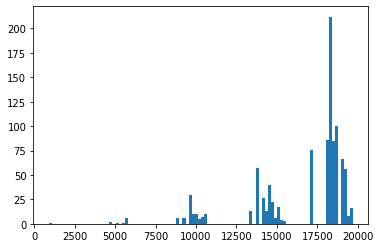

In [13]:
plt.hist(profits, bins=100)
plt.show()

We then select a value for `alpha` equal to 0.05 as the confidence level for our preferred half-width, defined by `epsilon`. This then gives us the desired number of runs:

In [14]:
alpha = 0.05
z = stats.norm.ppf(1-alpha/2)

epsilon = 0.01*np.mean(profits) # half-width
n = int(np.ceil((z*sigma/epsilon)**2))
print("n:", n)

n: 1235


Next, we find the profits for this number of runs `n`, rounded up to the nearest hundred and the corresponding confidence interval for the sample mean.

In [17]:
# Now find profits for this number of runs...
n_rounded = int(math.ceil(n / 100.0)) * 100
profits = calculate_profits(item_sizes, x, r, pi, num_runs=n_rounded, problem_instance=problem_instance)

# and find the confidence interval
half_width = z*sigma/math.sqrt(n)
confidence_interval = (np.mean(profits) - half_width, np.mean(profits) + half_width)
print("Confidence interval:", confidence_interval)

Confidence interval: (16450.81443799485, 16784.817818468415)


# Stochastic Programming Models
## Part 4.

The model: 
\begin{align*}
    \max_{x, \varepsilon_u,\eta, S_u } \; (1-\beta) \left [ \sum_{u \in U} P_u \left ( \sum_{i=1}^{10} r_i w_{iu} x_i - p \varepsilon_u \right ) \right ] + \beta \left [ \eta - \frac{1}{1-\alpha} \sum_{u \in U } P_u S_u \right ]
\end{align*}
subject to 
\begin{align*}
    \begin{aligned}
     x_i & \in \{0,1\} & \quad & \text{ for all } i \in I \\
     \varepsilon_u & \geq 0 & \quad & \text{ for all } u \in U \\
    \varepsilon_u & \geq \sum_{i=1} ^{10} w_{iu} x_i - K  & \quad &  \text{ for all } u \in U \\
    S_u & \geq 0 & \quad & \text{ for all } u \in U \\
    S_u & \geq \eta - \left ( \sum_{i=1}^{10} r_i w_{iu} x_i - p \varepsilon_u \right ) & \quad & \text{ for all } u \in U.
\end{aligned}
\end{align*}


In [18]:
#### Create all 1024 scenarios ####
# Binary scenarios creates all possible permutations of 0 and 1
def create_scenarios(problem_instance):
    binary_scenarios = [list(i) for i in itertools.product([0, 1], repeat=num_items)]

    # We will, without loss of generality, define that a 1 in binary_scenarios corresponds with a high weight
    scenario_weights = [[item_sizes[problem_instance]['dh'][i] if scenario[i] == 1
                         else item_sizes[problem_instance]['dl'][i]
                         for i in range(num_items)]
                        for scenario in binary_scenarios]
    scenario_probabilities = [np.prod([pi[i] if scenario[i] == 1 else (1-pi[i])
                                       for i in range(num_items)])
                              for scenario in binary_scenarios]
    
    return scenario_weights, scenario_probabilities

## Model formulation in Gurobi

In [19]:
def gurobi_optimization(problem_instance,beta,alpha,r,p,K):

    # Generate scenarios for problem instance
    scenario_weights, scenario_probabilities = create_scenarios(problem_instance)
    
    # Misc
    items = range(num_items)
    scenarios = range(len(scenario_weights))

    if beta == 0:
        alpha = alpha["EV"]
    else:
        alpha = alpha["CVaR"]
    
    # Create empty model
    m = gb.Model()
    m.setParam('OutputFlag', 0)
    # Create variables 
    x = m.addVars(items, vtype=gb.GRB.BINARY, name= "x")
    eta = m.addVars(1, vtype=gb.GRB.CONTINUOUS, name="eta")
    epsilon = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="epsilon", lb=0) 
    s = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="s", lb=0)

    # Set objective function
    def scenario_profit(scenario):
        return gb.quicksum(r[item]*scenario_weights[scenario][item]*x[item]-p*epsilon[scenario] for item in items)

    obj_1 = (1-beta)*gb.quicksum(scenario_probabilities[scenario]*scenario_profit(scenario) for scenario in scenarios)
    obj_2 = beta*(eta[0]-(1/(1-alpha))*gb.quicksum(scenario_probabilities[scenario]*s[scenario] for scenario in scenarios))

    m.setObjective(obj_1 + obj_2, gb.GRB.MAXIMIZE)

    # # Create constraints
    # Epsilon constraint
    for scenario in scenarios:
        m.addConstr(epsilon[scenario] >= gb.quicksum(scenario_weights[scenario][item]*x[item] for item in items) - K)

    # S constraint
    for scenario in scenarios:
        m.addConstr(s[scenario] >= eta[0] - scenario_profit(scenario))

    # Solve model
    m.optimize()
    
    return m

## Part 5.

In [20]:
# Solve EV model
model_solves_EV = [gurobi_optimization(instance,beta_model["EV"],alpha_model,r,p,K) for instance in range(num_instances)]
# model_solves_EV = gurobi_optimization(0,beta_model["EV"],alpha_model["EV"],r,p,K)

Academic license - for non-commercial use only


In [21]:
# Solve CVaR mode
model_solves_CVaR = [gurobi_optimization(instance, beta_model["CVaR"], alpha_model, r, p, K) for instance in range(num_instances)]
# model_solves_CVaR = gurobi_optimization(0, beta_model["EV"], alpha_model["CVaR"], r, p, K)

In [22]:
try:
    for j in range(num_instances):
        v_EV = model_solves_EV[j].getVars()
        v_CVaR = model_solves_CVaR[j].getVars()

        outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
        outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
        outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
        outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

        outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
        outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
        outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

        print("Result for instance", j+1)
        print("Maximum objective value: ", model_solves_EV[j].Objval)
        print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
        print("")
        print("Maximum objective value: ", model_solves_CVaR[j].Objval)
        print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
        print("")
except TypeError:
    v_EV = model_solves_EV.getVars()
    v_CVaR = model_solves_CVaR.getVars()

    outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
    outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
    outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
    outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

    outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
    outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
    outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
    outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

    print("Maximum objective value: ", model_solves_EV.Objval)
    print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
    print("")
    print("Maximum objective value: ", model_solves_CVaR.Objval)
    print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
    print("")

Result for instance 1
Maximum objective value:  14629.374682536607
EV   | x: [0, 0, 0, 1, 0, 0, 0, 1, 1, 1] | eta: [0]

Maximum objective value:  9689.949901109063
CVar | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [11661]

Result for instance 2
Maximum objective value:  15339.808183792346
EV   | x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1] | eta: [0]

Maximum objective value:  10031.358582811823
CVar | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [12107]

Result for instance 3
Maximum objective value:  15039.997476211218
EV   | x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1] | eta: [0]

Maximum objective value:  9769.45455698534
CVar | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [11899]

Result for instance 4
Maximum objective value:  14310.844199467268
EV   | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [0]

Maximum objective value:  9537.581366271468
CVar | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [11531]

Result for instance 5
Maximum objective value:  14983.208156931087
EV   | x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1] | eta: [

## Part 6. 

In [23]:
B=400+4*g
U=math.floor(60 + 0.1 * g)
alpha=0.95
profits = np.zeros(10)
alphaarr = np.zeros(10)
for i in range(10):
    
    # Solve CVaR mode
    model_solves_CVaR = [gurobi_optimization(instance, beta_model["CVaR"], alpha, r, U, B) for instance in range(num_instances)]
    # model_solves_CVaR = gurobi_optimization(0, beta_model["EV"], alpha_model["CVaR"], r, p(cost), K(size))

    try:
        for j in range(1):
           # v_EV = model_solves_EV[j].getVars()
            v_CVaR = model_solves_CVaR[j].getVars()

           # outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
          #  outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
          #  outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
        #    outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

            outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
            outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
            outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
            outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

            print("Result for instance", j+1)
          #  print("Maximum objective value: ", model_solves_EV[j].Objval)
          #  print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
           # print("")
            print("Maximum objective value: ", model_solves_CVaR[j].Objval)
            print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
            print("")
            
            profits[i]=model_solves_CVaR[j].Objval
            alphaarr[i] = alpha
    except TypeError:
     #   v_EV = model_solves_EV.getVars()
        v_CVaR = model_solves_CVaR.getVars()

        #outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
       # outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
       # outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
     #   outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

        outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
        outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
        outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

     #   print("Maximum objective value: ", model_solves_EV.Objval)
      #  print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
      #  print("")
        print("Maximum objective value: ", model_solves_CVaR.Objval)
        print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
        print(statistics.mean(outcome_x_CVaR))
        
  #  B=B+100
  #  U=U+5
    alpha=alpha-.05
print(profits)
print(alphaarr)

y = profits
x = alphaarr

plt.plot(x, y) 
  
plt.xlabel('alpha') 
# naming the y axis 
plt.ylabel('CVaR') 
  
# giving a title to my graph 
plt.title('Change in CVaR as alpha decreases') 
plt.xlim(0.95,0.5)
# function to show the plot 
plt.show() 

In [ ]:

B=400+4*g
U=math.floor(60 + 0.1 * g)
alpha=0.95
profits = np.zeros(30)
backsize = np.zeros(30)
for i in range(30):
    
    # Solve CVaR mode
    model_solves_CVaR = [gurobi_optimization(instance, beta_model["CVaR"], alpha, r, U, B) for instance in range(num_instances)]
    # model_solves_CVaR = gurobi_optimization(0, beta_model["EV"], alpha_model["CVaR"], r, p(cost), K(size))

    try:
        for j in range(1):
           # v_EV = model_solves_EV[j].getVars()
            v_CVaR = model_solves_CVaR[j].getVars()

           # outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
          #  outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
          #  outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
        #    outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

            outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
            outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
            outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
            outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

            print("Result for instance", j+1)
          #  print("Maximum objective value: ", model_solves_EV[j].Objval)
          #  print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
           # print("")
            print("Maximum objective value: ", model_solves_CVaR[j].Objval)
            print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
            print("")
            
            profits[i]=model_solves_CVaR[j].Objval
            backsize[i] = B
    except TypeError:
     #   v_EV = model_solves_EV.getVars()
        v_CVaR = model_solves_CVaR.getVars()

        #outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
       # outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
       # outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
     #   outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

        outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
        outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
        outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

     #   print("Maximum objective value: ", model_solves_EV.Objval)
      #  print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
      #  print("")
        print("Maximum objective value: ", model_solves_CVaR.Objval)
        print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
        print(statistics.mean(outcome_x_CVaR))
        
    B=B+12
    print(B)
  #  U=U+5
  #  alpha=alpha-.05
print(profits)
print(backsize)

y = profits
x = backsize

plt.plot(x, y, linestyle='none', marker='o') 
  
plt.xlabel('knapsack size') 
# naming the y axis 
plt.ylabel('CVaR') 
  
# giving a title to my graph 
plt.title('Change in CVaR as knapsack size increases') 
  
# function to show the plot 
plt.show() 

In [ ]:
B=400+4*g
U=math.floor(60 + 0.1 * g)
##U=25
alpha=0.95
profits =  np.zeros(10)
penalty =  np.zeros(10)
for i in range(10):
    
    # Solve CVaR mode
    model_solves_CVaR = [gurobi_optimization(instance, beta_model["CVaR"], alpha, r, U, B) for instance in range(num_instances)]
    # model_solves_CVaR = gurobi_optimization(0, beta_model["EV"], alpha_model["CVaR"], r, p(cost), K(size))

    try:
        for j in range(1):
           # v_EV = model_solves_EV[j].getVars()
            v_CVaR = model_solves_CVaR[j].getVars()

           # outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
          #  outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
          #  outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
        #    outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

            outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
            outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
            outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
            outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

            print("Result for instance", j+1)
          #  print("Maximum objective value: ", model_solves_EV[j].Objval)
          #  print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
           # print("")
            print("Maximum objective value: ", model_solves_CVaR[j].Objval)
            print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
            print("")
            
            profits[i]=model_solves_CVaR[j].Objval
            penalty[i] = U
    except TypeError:
     #   v_EV = model_solves_EV.getVars()
        v_CVaR = model_solves_CVaR.getVars()

        #outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
       # outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
       # outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
     #   outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

        outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
        outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
        outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

     #   print("Maximum objective value: ", model_solves_EV.Objval)
      #  print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
      #  print("")
        print("Maximum objective value: ", model_solves_CVaR.Objval)
        print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
        print(statistics.mean(outcome_x_CVaR))
        
   # B=B+50
    U=U-5
  #  alpha=alpha-.05
print(profits)
print(penalty)

y = profits
x = penalty

plt.plot(x, y) 
  
plt.xlabel('penalty') 
# naming the y axis 
plt.ylabel('CVaR') 
  
# giving a title to my graph 
plt.title('Change in CVaR as penalty decreases') 
plt.xlim(60,15)
# function to show the plot 
plt.show() 

# Sample Average Approximation
## Part 7.

#### Generate a random sample of $W^1, W^2, \dots, W^N$ of the weights

In [24]:
def generateWeights(pi,num_items,item_sizes,problem_instance):
    V = np.random.uniform(size=num_items)
    W = [item_sizes[problem_instance]["dh"][i] if V[i] < pi[i] else item_sizes[problem_instance]["dl"][i] 
        for i in range(num_items)]
    W = np.asarray(W)
    return W

def generateScenarios_SAA(pi,num_items,item_sizes,problem_instance,N):
    return [generateWeights(pi,num_items,item_sizes,problem_instance) for j in range(N)]

### Sample Average Approximation model 
\begin{align*}
    \max_{x, \varepsilon_u,\eta, S_u } \; (1-\beta) \left [ \frac{1}{N} \sum_{u=1}^N \left ( \sum_{i=1}^{10} r_i W^{u}_i x_i - p \varepsilon_u \right ) \right ] + \beta \left [ \eta - \frac{1}{1-\alpha} \frac{1}{N} \sum_{u=1 }^N S_u \right ] \tag{SAA}
    \end{align*}
subject to 
    \begin{align*}
    \begin{aligned}
     x_i & \in \{0,1\} & \quad & \text{ for all } i \in I \\
     \varepsilon_u & \geq 0 & \quad & \text{ for all } u \in U \\
    \varepsilon_u & \geq \sum_{i=1} ^{10} W^{u}_i x_i - K  & \quad &  \text{ for all } u \in U \\
    S_u & \geq 0 & \quad & \text{ for all } u \in U \\
    S_u & \geq \eta - \left ( \sum_{i=1}^{10} r_i W^{u}_i x_i - p \varepsilon_u \right ) & \quad & \text{ for all } u \in U.
    \end{aligned}
\end{align*}

### Model implentation in Gurobi

In [25]:
def gurobi_optimization_SAA(problem_instance,beta,alpha,r,p,K,N):

    # Generate scenarios for problem instance
    scenario_weights = generateScenarios_SAA(pi,num_items,item_sizes,problem_instance,N)
    scenarios = range(len(scenario_weights))
    scenario_probabilities = [1/N for j in range(N)]
    
    # Misc
    items = range(num_items)
    

    if beta == 0:
        alpha = alpha["EV"]
    else:
        alpha = alpha["CVaR"]
    
    # Create empty model
    m = gb.Model()
    m.setParam('OutputFlag', 0)

    # Create variables 
    x = m.addVars(items, vtype=gb.GRB.BINARY, name= "x")
    eta = m.addVars(1, vtype=gb.GRB.CONTINUOUS, name="eta")
    epsilon = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="epsilon", lb=0) 
    s = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="s", lb=0)

    # Set objective function
    def scenario_profit(scenario):
        return gb.quicksum(r[item]*scenario_weights[scenario][item]*x[item]-p*epsilon[scenario] for item in items)

    obj_1 = (1-beta)*gb.quicksum(scenario_probabilities[scenario]*scenario_profit(scenario) for scenario in scenarios)
    obj_2 = beta*(eta[0]-(1/(1-alpha))*gb.quicksum(scenario_probabilities[scenario]*s[scenario] for scenario in scenarios))

    m.setObjective(obj_1 + obj_2, gb.GRB.MAXIMIZE)

    # # Create constraints
    # Epsilon constraint
    for scenario in scenarios:
        m.addConstr(epsilon[scenario] >= gb.quicksum(scenario_weights[scenario][item]*x[item] for item in items) - K)

    # S constraint
    for scenario in scenarios:
        m.addConstr(s[scenario] >= eta[0] - scenario_profit(scenario))

    # Solve model
    m.optimize()
    
    return m

### Solve the SAA model $M$ times given a sample of size $N$ to obtain SAA solution

In [26]:
N = 2000
M = 10
problem_instance = 0 
SAA_solve_EV = [gurobi_optimization_SAA(problem_instance,beta_model["EV"], alpha_model,r,p,K,N) for j in range(M)]
SAA_solve_CVaR = [gurobi_optimization_SAA(problem_instance,beta_model["CVaR"], alpha_model,r,p,K,N) for j in range(M)]

# Store objective values to compute upper bound on v*
SAA_objectiveValues_EV = []
SAA_objectiveValues_CVaR = []


# Obtain SAA solution, which is the solution corresponding to the maximum out of M optimal values
maximumObjective_EV = 0
for j in range(M):
    SAA_objectiveValues_EV.append(SAA_solve_EV[j].objVal)
    
    if(SAA_solve_EV[j].objVal > maximumObjective_EV):
        maximumObjective_EV = SAA_solve_EV[j].objVal
        v_EV = SAA_solve_EV[j].getVars()
        SAA_solution_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]

maximumObjective_CVaR = 0
for j in range(M):
    SAA_objectiveValues_CVaR.append(SAA_solve_CVaR[j].objVal)
    
    if(SAA_solve_CVaR[j].objVal > maximumObjective_CVaR):
        maximumObjective_CVaR = SAA_solve_CVaR[j].objVal
        v_CVaR = SAA_solve_CVaR[j].getVars()
        SAA_solution_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        SAA_solution_CVaR_eta = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
        
print("Solution for instance ", problem_instance+1)
print("SAA solution EV model")
print("x = ", SAA_solution_EV)
print("SAA objective value EV model: ",maximumObjective_EV)
print("")
print("SAA solution CVaR model")
print("x = ", SAA_solution_CVaR)
print("eta = ", SAA_solution_CVaR_eta)
print("SAA objective value CVaR model: ",maximumObjective_CVaR)


        

KeyboardInterrupt: 

## Derivation of optimality gap

The optimality gap is defined by: 
\begin{align*}
        \mathrm{gap}(\hat{x}) =  v^* - g(\hat{x}),
    \end{align*}

### Upper bound for $v^*$ using $E(\hat{v}_N)$

Sample mean of $E(\hat{v}_N)$:
\begin{align*}
        \bar{v}_{N,M} = \frac{1}{M} \sum_{j = 1}^M \hat{v}^j_N.
    \end{align*}
    
Sample variance: 

\begin{align*}
        \hat{\sigma}^2_{N,M} = \frac{1}{M(M-1)} \sum_{j =1}^M (\hat{v}^j_N - \bar{v}_{N,M})^2.
\end{align*}


    

In [ ]:
# Sample mean
sample_mean_UB_EV = np.mean(SAA_objectiveValues_EV)
sample_mean_UB_CVaR = np.mean(SAA_objectiveValues_CVaR)

# Sample standard deviation
sample_std_UB_EV = np.power((np.std(SAA_objectiveValues_EV)**2)/(M-1),0.5)
sample_std_UB_CVaR = np.power((np.std(SAA_objectiveValues_CVaR)**2)/(M-1),0.5)

print("EV Model: ")
print("Sample mean: ",sample_mean_UB_EV)
print("Standard deviation of sample mean: ",sample_std_UB_EV)

print("CVaR Model: ")
print("Sample mean: ",sample_mean_UB_CVaR)
print("Standard deviation of sample mean: ",sample_std_UB_CVaR)

### 95% upper bound for $v^*$
 \begin{align*}
        U_{N,M} = \bar{v}_{N,M} + t_{\gamma,\nu}\hat{\sigma}_{N,M},
    \end{align*}
    where $\nu = M-1$ and $t_{\gamma,\nu}$ is the $\gamma$-critical value of the $t$-distribution with $\nu$ degrees of freedom.

In [ ]:
nu = M-1
gamma = 0.05
critical_value_t = stats.t.ppf(1-gamma,nu)

gap_UB_EV = sample_mean_UB_EV + critical_value_t*sample_std_UB_EV
gap_UB_CVaR = sample_mean_UB_CVaR + critical_value_t*sample_std_UB_CVaR

print(100*(1-gamma),"% upper bound (EV model): ",gap_UB_EV )
print(100*(1-gamma),"% upper bound (CVaR model): ",gap_UB_CVaR )

## Lower bound for $g(\hat{x})$ 

### First generate random sample $W^1, W^2, \dots, W^{N'}$ of size $N'$

In [ ]:
N_prime = 10000
scenario_weights_SAA = generateScenarios_SAA(pi,num_items,item_sizes,problem_instance,N_prime)

## Then, compute the sample mean $\hat{g}_{N'}(\hat{x})$ and sample variance of $\hat{g}_{N'}(\hat{x})$

Let 
    \begin{align*}
        Q(\hat{x},W^{u}) = (1-\beta)\left ( \sum_{i=1}^{10} r_i W^{u}_i \hat{x}_i - p \varepsilon_u \right ) + \beta \left [ \eta - \frac{1}{1-\alpha} S_u \right ],
    \end{align*}
    where $\varepsilon_u = \max \{0, \sum_{i=1} ^{10} W^{u}_i \hat{x}_i - K \}$ and $S_u = \max \{0,\eta - (\sum_{i=1}^{10} r_i W^{u}_i \hat{x}_i - p \varepsilon_u ) \}$ for all $u \in U$. 
    Then, the sample average is given by
    \begin{align*}
        \hat{g}_{N'}(\hat{x}) = \frac{1}{N'} \sum_{u=1 }^{N'}  Q(\hat{x},W^{u}),
    \end{align*}
    and the sample variance of $\hat{g}_{N'}(\hat{x})$ is given by
    \begin{align*}
        \hat{\sigma}^2_{N'}(\hat{x}) = \frac{1}{N'(N'-1)} \sum_{u=1}^{N'} \left [ Q(\hat{x},W^{u}) - \hat{g}_{N'}(\hat{x}) \right ]^2.
    \end{align*}

In [ ]:
def scenario_profit_given_x_hat(x,alpha,beta,r,p,K,eta,scenario_weight):
    scenario_excess = max(0,sum(scenario_weight*x)-K)
    profit_EV = sum(r*scenario_weight*x)-p*scenario_excess   
    profit_CVaR = eta[0]-(1/(1-alpha))*max(0,eta[0]-profit_EV)
    return (1-beta)*profit_EV + beta*profit_CVaR

LB_scenarios = range(len(scenario_weights_SAA))

Q_EV = [scenario_profit_given_x_hat(SAA_solution_EV,0,beta_model["EV"],r,p,K,SAA_solution_CVaR_eta,scenario_weights_SAA[scenario]) for scenario in LB_scenarios]

Q_CVaR = [scenario_profit_given_x_hat(SAA_solution_CVaR,0.95,beta_model["CVaR"],r,p,K,SAA_solution_CVaR_eta,scenario_weights_SAA[scenario]) for scenario in LB_scenarios]

# Sample mean
sample_mean_LB_EV = np.mean(Q_EV)
sample_mean_LB_CVaR = np.mean(Q_CVaR)

# Sample standard deviation
sample_std_LB_EV = np.power((np.std(Q_EV)**2)/(N_prime-1),0.5)
sample_std_LB_CVaR = np.power((np.std(Q_CVaR)**2)/(N_prime-1),0.5)

print("EV Model: ")
print("Sample mean: ",sample_mean_LB_EV)
print("Standard deviation of sample mean: ",sample_std_LB_EV)

print("CVaR Model: ")
print("Sample mean: ",sample_mean_LB_CVaR)
print("Standard deviation of sample mean: ",sample_std_LB_CVaR)


### 95% lower bound for $g(\hat{x})$
\begin{align*}
        L_{N'} = \hat{g}_{N'}(\hat{x}) - z_{\gamma} \hat{\sigma}_{N'}(\hat{x}),
    \end{align*}
    where $z_{\gamma}$ is the $\gamma$-critical value of the standard normal distribution

In [ ]:
critical_value_z = stats.norm.ppf(1-gamma,0,1)
gap_LB_EV = sample_mean_LB_EV - critical_value_z*sample_std_LB_EV
gap_LB_CVaR = sample_mean_LB_CVaR - critical_value_z*sample_std_LB_CVaR

print(100*(1-gamma),"% lower bound (EV model): ",gap_LB_EV )
print(100*(1-gamma),"% lower bound (CVaR model): ",gap_LB_CVaR )

## 90% confidence bound on the true $\mathrm{gap}(\hat{x})$ 
Gap: 
    \begin{align*}
        \widehat{gap}(\hat{x}) = U_{N,M} - L_{N'}.
    \end{align*}

In [ ]:
gap_EV = gap_UB_EV - gap_LB_EV
gap_CVaR = gap_UB_CVaR - gap_LB_CVaR

print(100*(1-2*gamma),"% confidence bound on true gap (EV model): ",gap_EV )
print(100*(1-2*gamma),"% confidence bound on true gap  (CVaR model): ", gap_CVaR )

# Bonus question

### Generate two random sample batches of the weights $W^1,\dots,W^N$ using $V$ and $1-V$

In [ ]:
def generateWeights_AV(pi,num_items,item_sizes,problem_instance):
    V1 = np.random.uniform(size=num_items)
    W1 = [item_sizes[problem_instance]["dh"][i] if V1[i] < pi[i] else item_sizes[problem_instance]["dl"][i] 
        for i in range(num_items)]
    W1 = np.asarray(W1)

    V2 = 1-V1
    W2 = [item_sizes[problem_instance]["dh"][i] if V2[i] < pi[i] else item_sizes[problem_instance]["dl"][i] 
        for i in range(num_items)]
    W2 = np.asarray(W2)
    
    return W1, W2

def generateScenarios_SAA_AV(pi,num_items,item_sizes,problem_instance,N): 
    
    scenarios_SAA_AV_1 = []
    scenarios_SAA_AV_2 = []
    
    for j in range(N):
        W = generateWeights_AV(pi,num_items,item_sizes,problem_instance)
        scenarios_SAA_AV_1.append(W[0])
        scenarios_SAA_AV_2.append(W[1])
  
    return scenarios_SAA_AV_1, scenarios_SAA_AV_2

### Slight edit to Gurobi implementation, i.e. scenario weights are input

In [ ]:
def gurobi_optimization_SAA_AV(problem_instance,beta,alpha,r,p,K,N,scenario_weights_AV):

    # Generate scenarios for problem instance
    scenario_weights = scenario_weights_AV
    scenarios = range(len(scenario_weights))
    scenario_probabilities = [1/N for j in range(N)]
    
    # Misc
    items = range(num_items)
    

    if beta == 0:
        alpha = alpha["EV"]
    else:
        alpha = alpha["CVaR"]
    
    # Create empty model
    m = gb.Model()
    m.setParam('OutputFlag', 0)

    # Create variables 
    x = m.addVars(items, vtype=gb.GRB.BINARY, name= "x")
    eta = m.addVars(1, vtype=gb.GRB.CONTINUOUS, name="eta")
    epsilon = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="epsilon", lb=0) 
    s = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="s", lb=0)

    # Set objective function
    def scenario_profit(scenario):
        return gb.quicksum(r[item]*scenario_weights[scenario][item]*x[item]-p*epsilon[scenario] for item in items)

    obj_1 = (1-beta)*gb.quicksum(scenario_probabilities[scenario]*scenario_profit(scenario) for scenario in scenarios)
    obj_2 = beta*(eta[0]-(1/(1-alpha))*gb.quicksum(scenario_probabilities[scenario]*s[scenario] for scenario in scenarios))

    m.setObjective(obj_1 + obj_2, gb.GRB.MAXIMIZE)

    # # Create constraints
    # Epsilon constraint
    for scenario in scenarios:
        m.addConstr(epsilon[scenario] >= gb.quicksum(scenario_weights[scenario][item]*x[item] for item in items) - K)

    # S constraint
    for scenario in scenarios:
        m.addConstr(s[scenario] >= eta[0] - scenario_profit(scenario))

    # Solve model
    m.optimize()
    
    return m

### Solve SAA scheme $M$ times 
Get pairs $(\hat{v}^{1,1}_N,\hat{v}^{1,2}_N), (\hat{v}^{2,1}_N,\hat{v}^{2,2}_N), \dots, (\hat{v}^{M,1}_N,\hat{v}^{M,2}_N) $

Then determine $\hat{v}^{j}_N = (\hat{v}^{j,1}_N+\hat{v}^{j,2}_N)/2$ for all $j=1,\dots,M$ and get SAA solution $\hat{x}$

In [ ]:
M = 5

# Solve EV model
SAA_solve_EV_AV = []
SAA_EV_maxObjective = 0

for j in range(M):
    scenario_weights_AV = generateScenarios_SAA_AV(pi,num_items,item_sizes,problem_instance,N)
    
    # Pairs of solutions 
    sol1 = gurobi_optimization_SAA_AV(problem_instance,beta_model["EV"], alpha_model,r,p,K,N,scenario_weights_AV[0])
    if(sol1.objVal > SAA_EV_maxObjective):
        SAA_EV_maxObjective = sol1.objVal
        EV_AV = sol1.getVars()
        SAA_solution_EV_AV = [int(EV_AV[i].x) for i in range(len(EV_AV)) if (re.sub("\[\d+\]", "", EV_AV[i].varName) == "x")]
        
    sol2 = gurobi_optimization_SAA_AV(problem_instance,beta_model["EV"], alpha_model,r,p,K,N,scenario_weights_AV[1])
    if(sol2.objVal > SAA_EV_maxObjective):
        SAA_EV_maxObjective = sol2.objVal
        EV_AV = sol2.getVars()
        SAA_solution_EV_AV = [int(EV_AV[i].x) for i in range(len(EV_AV)) if (re.sub("\[\d+\]", "", EV_AV[i].varName) == "x")]     
        
    SAA_solve_EV_AV.append((sol1.objVal+sol2.objVal)/2)
    
# Solve CVaR model
SAA_solve_CVaR_AV = []
SAA_CVaR_maxObjective = 0

for j in range(M):
    scenario_weights_AV = generateScenarios_SAA_AV(pi,num_items,item_sizes,problem_instance,N)
    
    # Pairs of solutions 
    sol1 = gurobi_optimization_SAA_AV(problem_instance,beta_model["CVaR"], alpha_model,r,p,K,N,scenario_weights_AV[0])
    if(sol1.objVal > SAA_CVaR_maxObjective):
        SAA_CVaR_maxObjective = sol1.objVal
        CVaR_AV = sol1.getVars()
        SAA_solution_CVaR_AV = [int(CVaR_AV[i].x) for i in range(len(CVaR_AV)) if (re.sub("\[\d+\]", "", CVaR_AV[i].varName) == "x")]
        SAA_solution_CVaR_eta_AV = [int(CVaR_AV[i].x) for i in range(len(CVaR_AV)) if (re.sub("\[\d+\]", "", CVaR_AV[i].varName) == "eta")]
        
    sol2 = gurobi_optimization_SAA_AV(problem_instance,beta_model["CVaR"], alpha_model,r,p,K,N,scenario_weights_AV[1])
    if(sol2.objVal > SAA_CVaR_maxObjective):
        SAA_CVaR_maxObjective = sol2.objVal
        CVaR_AV = sol2.getVars()
        SAA_solution_CVaR_AV = [int(CVaR_AV[i].x) for i in range(len(CVaR_AV)) if (re.sub("\[\d+\]", "", CVaR_AV[i].varName) == "x")]     
        SAA_solution_CVaR_eta_AV = [int(CVaR_AV[i].x) for i in range(len(CVaR_AV)) if (re.sub("\[\d+\]", "", CVaR_AV[i].varName) == "eta")]
        
    SAA_solve_CVaR_AV.append((sol1.objVal+sol2.objVal)/2)
        
    


In [ ]:
# SAA solution EV model
print("EV model: ")
print("SAA solution with antithetic variates: ", SAA_solution_EV_AV)
print("Objective value of SAA solution: ", SAA_EV_maxObjective)
print("")

# Sample mean
sample_mean_UB_EV_AV = np.mean(SAA_solve_EV_AV)


# Sample standard deviation
sample_std_UB_EV_AV = np.power((np.std(SAA_solve_EV_AV)**2)/(M-1),0.5)


print("Sample mean with AV: ",sample_mean_UB_EV_AV)
print("Standard deviation of sample mean with AV: ",sample_std_UB_EV_AV)
print("")
print("Sample mean without AV: ",sample_mean_UB_EV)
print("Standard deviation of sample mean without AV: ",sample_std_UB_EV)
print("")

# SAA solution CVaR model
print("CVaR model: ")
print("SAA solution with antithetic variates: x= ", SAA_solution_CVaR_AV)
print("SAA solution with antithetic variates: eta= ", SAA_solution_CVaR_eta_AV)
print("Objective value of SAA solution: ", SAA_CVaR_maxObjective)
print("")

# Sample mean
sample_mean_UB_CVaR_AV = np.mean(SAA_solve_CVaR_AV)


# Sample standard deviation
sample_std_UB_CVaR_AV = np.power((np.std(SAA_solve_CVaR_AV)**2)/(M-1),0.5)


print("Sample mean with AV: ",sample_mean_UB_CVaR_AV)
print("Standard deviation of sample mean with AV: ",sample_std_UB_CVaR_AV)
print("")
print("Sample mean without AV: ",sample_mean_UB_CVaR)
print("Standard deviation of sample mean without AV: ",sample_std_UB_CVaR)


### Generate two random sample batches of the weights $W^1,\dots,W^{N'}$ using $V$ and $1-V$ and obtain $Q_1(\hat{x},W^1), \dots, Q_1(\hat{x},W^{N'})$ and $Q_2(\hat{x},W^1), \dots, Q_2(\hat{x},W^{N'})$

Then compute $Q(\hat{x},W^u) =  (Q_1(\hat{x},W^u)+Q_2(\hat{x},W^u))/2 $ for all $u =1,\dots, N'$

In [ ]:
N_prime = 5000
scenario_weights_SAA_AV = generateScenarios_SAA_AV(pi,num_items,item_sizes,problem_instance,N_prime)

LB_scenarios_AV = range(len(scenario_weights_SAA_AV[0]))

Q_EV_AV_1 = [scenario_profit_given_x_hat(SAA_solution_EV_AV,0,beta_model["EV"],r,p,K,SAA_solution_CVaR_eta_AV,scenario_weights_SAA_AV[0][scenario]) for scenario in LB_scenarios_AV]
Q_EV_AV_2 = [scenario_profit_given_x_hat(SAA_solution_EV_AV,0,beta_model["EV"],r,p,K,SAA_solution_CVaR_eta_AV,scenario_weights_SAA_AV[1][scenario]) for scenario in LB_scenarios_AV]

Q_CVaR_AV_1 = [scenario_profit_given_x_hat(SAA_solution_CVaR_AV,0.95,beta_model["CVaR"],r,p,K,SAA_solution_CVaR_eta_AV,scenario_weights_SAA_AV[0][scenario]) for scenario in LB_scenarios_AV]
Q_CVaR_AV_2 = [scenario_profit_given_x_hat(SAA_solution_CVaR_AV,0.95,beta_model["CVaR"],r,p,K,SAA_solution_CVaR_eta_AV,scenario_weights_SAA_AV[1][scenario]) for scenario in LB_scenarios_AV]

Q_EV_AV = (np.array(Q_EV_AV_1)+np.array(Q_EV_AV_2))/2
Q_CVaR_AV = (np.array(Q_CVaR_AV_1)+np.array(Q_CVaR_AV_2))/2


# Sample mean
sample_mean_LB_EV_AV = np.mean(Q_EV_AV)
sample_mean_LB_CVaR_AV = np.mean(Q_CVaR_AV)

# Sample standard deviation
sample_std_LB_EV_AV = np.power((np.std(Q_EV_AV)**2)/(N_prime-1),0.5)
sample_std_LB_CVaR_AV = np.power((np.std(Q_CVaR_AV)**2)/(N_prime-1),0.5)

print("EV Model: ")
print("Sample mean with AV: ",sample_mean_LB_EV_AV)
print("Standard deviation of sample mean with AV: ",sample_std_LB_EV_AV)
print("")
print("Sample mean without AV: ",sample_mean_LB_EV)
print("Standard deviation of sample mean without AV: ",sample_std_LB_EV)


print("CVaR Model: ")
print("Sample mean with AV: ",sample_mean_LB_CVaR_AV)
print("Standard deviation of sample mean with AV: ",sample_std_LB_CVaR_AV)
print("")
print("Sample mean without AV: ",sample_mean_LB_CVaR)
print("Standard deviation of sample mean without AV: ",sample_std_LB_CVaR)


## Determine $90\%$ confidence bound on the true $\mathrm{gap}(\hat{x})$ using antithetic variates 

Gap is given by
    \begin{align*}
        \widehat{gap}(\hat{x}) = U_{N,M} - L_{N'}.
    \end{align*}

In [ ]:
# Upper bound
nu = M-1
gamma = 0.05
critical_value_t_AV = stats.t.ppf(1-gamma,nu)

gap_UB_EV_AV = sample_mean_UB_EV_AV + critical_value_t_AV*sample_std_UB_EV_AV
gap_UB_CVaR_AV = sample_mean_UB_CVaR_AV + critical_value_t*sample_std_UB_CVaR_AV

# Lower bound
critical_value_z_AV = stats.norm.ppf(1-gamma,0,1)
gap_LB_EV_AV = sample_mean_LB_EV_AV - critical_value_z_AV*sample_std_LB_EV_AV
gap_LB_CVaR_AV = sample_mean_LB_CVaR_AV - critical_value_z*sample_std_LB_CVaR_AV


# Gap 
gap_EV_AV = gap_UB_EV_AV - gap_LB_EV_AV
gap_CVaR_AV = gap_UB_CVaR_AV - gap_LB_CVaR_AV

print(100*(1-2*gamma),"% confidence bound on true gap (EV model) with AV: ",gap_EV_AV )
print(100*(1-2*gamma),"% confidence bound on true gap  (CVaR model) with AV: ", gap_CVaR_AV )
print("")
print(100*(1-2*gamma),"% confidence bound on true gap (EV model) without AV: ",gap_EV )
print(100*(1-2*gamma),"% confidence bound on true gap  (CVaR model) without AV: ", gap_CVaR )

## OLD

In [ ]:
def gurobi_model(r, K, p,scenario_weights, scenario_probabilities, beta=0, alpha=0.95, save_path=None):
    model = gb.Model("expected_value")
    
    num_items = len(scenario_weights[0])
    
    items = range(num_items)
    scenarios = range(len(scenario_weights))
    
    if beta == 0:
        alpha = alpha["EV"]
    else:
        alpha = alpha["CVaR"]
    
    # Define variables
    x = model.addVars(items, vtype=gb.GRB.BINARY, name= "x")
    epsilon = model.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="epsilon", lb=0)
    eta = model.addVars(1, vtype=gb.GRB.CONTINUOUS, name="eta")
    s = model.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="s", lb=0)

    model.update()

    #### Write objective ####
    obj = gb.LinExpr()

    # Expected value objective
    for scenario in scenarios:
        for item in items:
            obj += (1-beta)*scenario_probabilities[scenario]*r[item]*scenario_weights[scenario][item]*x[item]
        obj -= (1-beta)*p*epsilon[scenario]

    # CVaR Objective:
    # Part 1
    obj += beta*eta[0]

    # Part 2
    for scenario in scenarios:
        # TODO: ask why we do 1/(1-a); what does it mean in practice (with relation to quantile)
        obj -= beta*(1/(1-alpha))*scenario_probabilities[scenario]*s[scenario]

    model.setObjective(obj, gb.GRB.MAXIMIZE)

    #### Write constraints ####
    # Epsilon constraint
    for scenario in scenarios:
        model.addConstr(epsilon[scenario] >= sum([scenario_weights[scenario][item]*x[item] for item in items]) - K,
                        name=f"epsilon_constraint_scenario_{scenario}")

    # S constraint
    for scenario in scenarios:
        model.addConstr(s[scenario] >= eta[0] - (sum([r[item]*scenario_weights[scenario][item]*x[item] for item in items])
                                                 - p*epsilon[scenario]),
                        name=f"s_constraint_scenario_{scenario}")
    
    # Update and, possibly, save model before optimising
    model.update()
    
    if save_path != None:
        model.write(f'{save_path}.lp')
        
    model.optimize()
    
    return model

In [ ]:
# # Part 5
# # Part 6

# Sample Average Approximation
# # Part 7

# Analysis
# # Part 8

# # Part 9

# # Bonus